In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

In [55]:


class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} 

In [56]:
%%add_to DynaQAgent



def update_model(self, past_state, past_action, state, reward):
    if past_state not in self.model:
        self.model[past_state] = {}
    self.model[past_state][past_action] = (state, reward)
    

In [57]:
%%add_to DynaQAgent

def planning_step(self):
    
    for _ in range(self.planning_steps):
        past_state = self.planning_rand_generator.choice(list(self.model.keys()))
        past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
        state, reward = self.model[past_state][past_action]
        if state != -1:
            self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
        else:
            self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])

In [58]:
%%add_to DynaQAgent



def argmax(self, q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [59]:
%%add_to DynaQAgent



def agent_start(self, state): 
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    
    
    return self.past_action

def agent_step(self, reward, state):
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, state, reward)
    
    self.planning_step()
    
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    
    
    return self.past_action

def agent_end(self, reward):
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, -1, reward)
    
    self.planning_step()
    

In [60]:


def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          
        agent_info["planning_steps"] = planning_steps  

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  
            rl_glue.rl_init(agent_info, env_info) 

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  
                is_terminal = False            
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/" + result_file_name, log_data)

def plot_cumulative_reward(file_path, item_key, y_key, y_axis_label, legend_prefix, title):

    data_all = np.load(file_path, allow_pickle=True).item()
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

Planning steps :  5


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Planning steps :  10


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Planning steps :  50


100%|██████████| 10/10 [02:22<00:00, 14.22s/it]


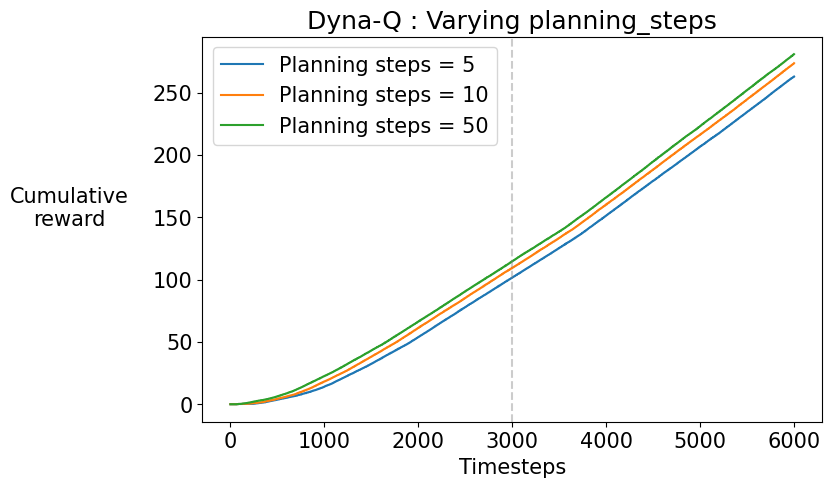

In [61]:



experiment_parameters = {
    "num_runs" : 10,                     
    "num_max_steps" : 6000,              
}


environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}


agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [5, 10, 50]      
}

current_env = ShortcutMazeEnvironment   
current_agent = DynaQAgent              

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")    
plot_cumulative_reward('results/Dyna-Q_shortcut_steps.npy', 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q : Varying planning_steps')

In [77]:


def plot_state_visitations(file_path, plot_titles, idx):

    data = np.load(file_path, allow_pickle=True).item()
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i in range(2):

        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape((6,9)).T)
        grid_state_visits[2,1:wall_ends[i]] = np.nan 
        
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(8+0.5, 5+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()

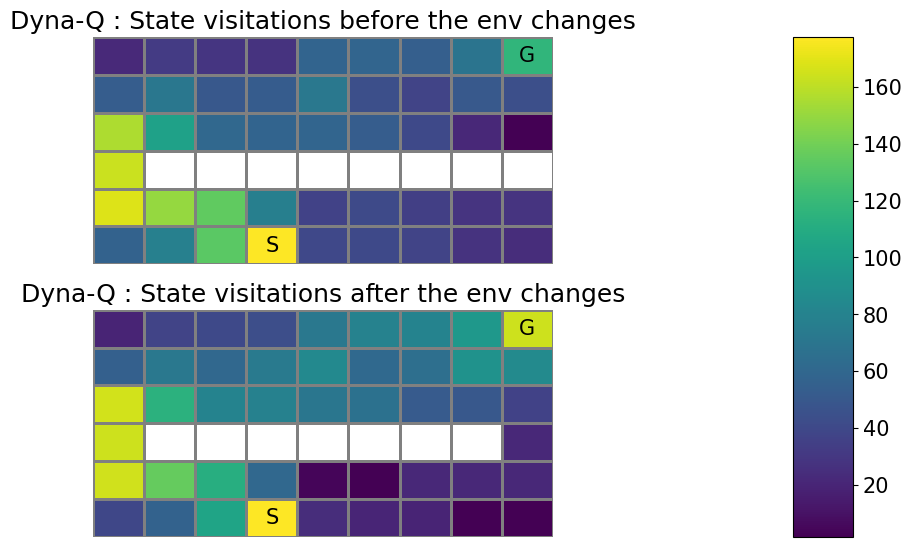

In [78]:


plot_state_visitations("results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 1)

In [64]:


class DynaQPlusAgent(BaseAgent):
    
    def agent_init(self, agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.001)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        
        
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

In [65]:
%%add_to DynaQPlusAgent
def update_model(self, past_state, past_action, state, reward):
    if past_state not in self.model:
        self.model[past_state] = {past_action : (state, reward)}
        
        for action in self.actions:
            if action != past_action:
                self.model[past_state][action] = (past_state, 0)
        
    else:
        self.model[past_state][past_action] = (state, reward)
    

In [66]:
%%add_to DynaQPlusAgent



def planning_step(self):
    
    for _ in range(self.planning_steps):
        past_state = self.planning_rand_generator.choice(list(self.model.keys()))
        past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
        state, reward = self.model[past_state][past_action]
        reward += self.kappa * np.sqrt(self.tau[past_state][past_action])
        if state != -1:
            self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
        else:
            self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])
    

In [67]:
%%add_to DynaQPlusAgent



def argmax(self, q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [68]:
%%add_to DynaQPlusAgent


    
def agent_start(self, state):
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    
    
    return self.past_action

def agent_step(self, reward, state):
    self.tau += 1
    self.tau[self.past_state][self.past_action] = 0
    
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, state, reward)
    
    self.planning_step()
    
    action = self.choose_action_egreedy(state)
    
    self.past_state = state
    self.past_action = action
    
    
    return self.past_action

def agent_end(self, reward):
    self.tau += 1
    self.tau[self.past_state][self.past_action] = 0
    
    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])
    
    self.update_model(self.past_state, self.past_action, -1, reward)
    
    self.planning_step()
    

In [69]:



experiment_parameters = {
    "num_runs" : 30,                     
    "num_max_steps" : 6000,              
}


environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}


agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [50]      
}

current_env = ShortcutMazeEnvironment   
current_agent = DynaQPlusAgent          

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")


Planning steps :  50


100%|██████████| 30/30 [07:39<00:00, 15.33s/it]


In [74]:


def plot_cumulative_reward_comparison(file_name_dynaq, file_name_dynaqplus):

    cum_reward_q = np.load(file_name_dynaq, allow_pickle=True).item()['cum_reward_all'][2]
    cum_reward_qPlus = np.load(file_name_dynaqplus, allow_pickle=True).item()['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

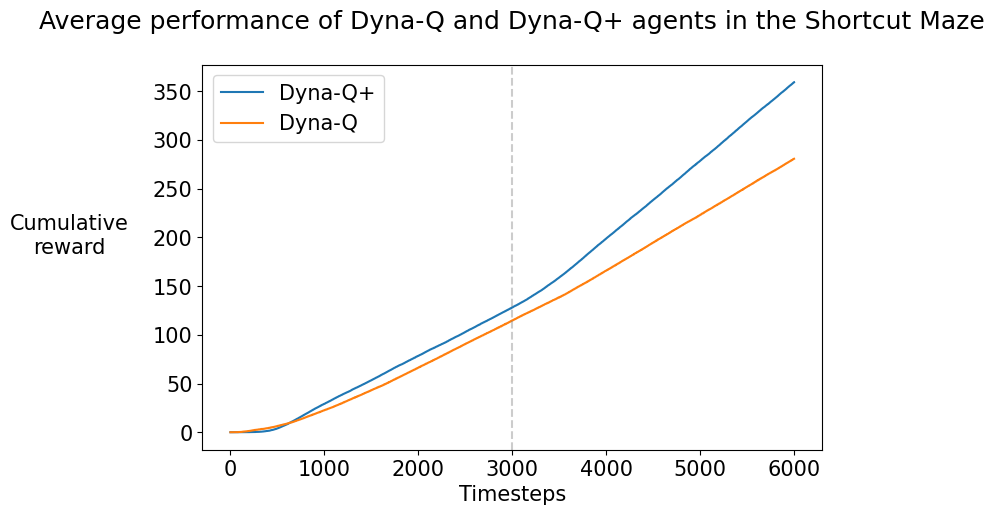

In [75]:


plot_cumulative_reward_comparison('results/Dyna-Q_shortcut_steps.npy', 'results/Dyna-Q+.npy')

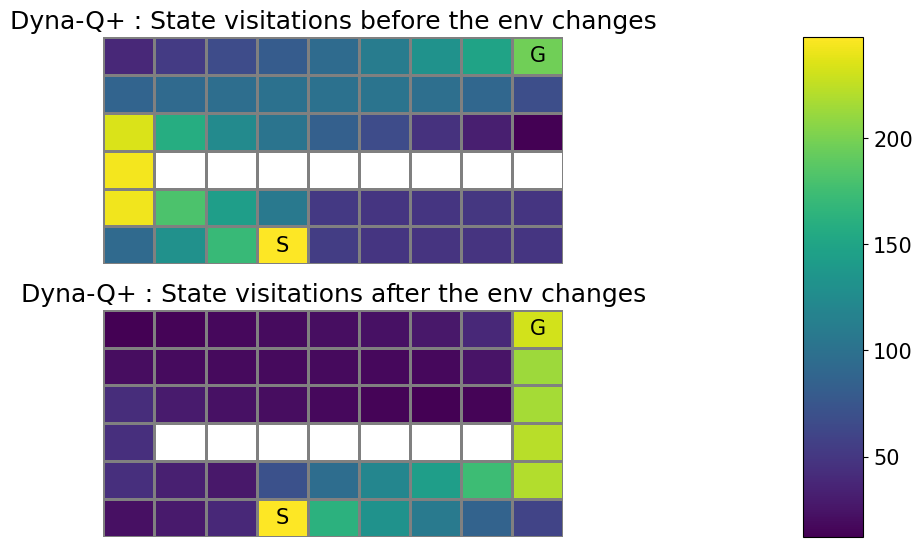

In [79]:


plot_state_visitations("results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0)